In [2]:
import Ramsey_ExperimentV3
import estimator
import numpy as np

In [18]:
from tqdm import tqdm
import random

T = np.pi
uni_delay = np.linspace(0, T, 20)
# shots = np.arange(500, 20000, 2000)
shots= np.logspace(3,5,num=6-2+1,base=10,dtype='int')
errors_fisher = []
errors_local = []
uniform_local = []
uniform_local_G = []
n = 1
delay = [1]
fisher_delay = [0.4439410861020235, 1.784695781691183]


repetitions = 200


for rep in range(repetitions):
    rep_error_fisher = []
    rep_error_local = []
    rep_error_uniform = []
    rep_error_uniform_G = []


    W = [random.gauss(1, 0) for _ in range(n)]
    Decay = [random.gauss(1, 0) for _ in range(n)]
    J = {}
    J_list = [random.gauss(1, 0) for _ in range(n - 1)]
    for i in range(n - 1):  # Only connect to the next neighbor
        J[(i, i + 1)] = J_list[i]

    for s in tqdm(shots, desc=f"Repetition {rep}"):
        # batch_x, batch_y = Ramsey_ExperimentV2.ramsey_global(n, s, delay, Decay, W, J)
        batch_x_det, batch_y_det, batch_x_cross, batch_y_cross = Ramsey_ExperimentV3.ramsey_local(n, s, delay, Decay,
                                                                                                  W, J)
        # batch_x_det_uni, batch_cross_uni = Ramsey_ExperimentV3.ramsey_local_X(n, s, uni_delay, Decay, W, J)
        batch_x_det_uni,batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni = Ramsey_ExperimentV3.ramsey_local(n, s, uni_delay, Decay, W, J)
        batch_x_det_uni_G,batch_y_det_uni_G, batch_x_cross_uni_G, batch_y_cross_uni_G = Ramsey_ExperimentV3.ramsey_local_gausian(n, s,delay[0],delay[0], uni_delay, Decay, W, J)


        batch_det, batch_cross = Ramsey_ExperimentV3.ramsey_local_X(n, s, fisher_delay, Decay, W, J)

        Decay_local, W_local, J_local = estimator.one_by_one_fit(batch_x_det, batch_y_det, batch_x_cross,
                                                                 batch_y_cross)
        Decay_fisher, W_fisher, J_fisher = estimator.one_by_one_X(batch_det, batch_cross)

        # Decay_uni, W_uni, J_uni = estimator.one_by_one_X(batch_x_det_uni, batch_cross_uni)
        Decay_uni, W_uni, J_uni = estimator.one_by_one_fit(batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni)
        # Decay_uni_G, W_uni_G, J_uni_G = estimator.one_by_one_fit(batch_x_det_uni_G, batch_y_det_uni_G, batch_x_cross_uni_G, batch_y_cross_uni_G)


        rep_error_fisher.append(estimator.percent_error(np.concatenate([Decay, W, J_list]),
                                                        np.concatenate([Decay_fisher, W_fisher, J_fisher])))
        rep_error_local.append(estimator.percent_error(np.concatenate([Decay, W, J_list]),
                                                       np.concatenate([Decay_local, W_local, J_local])))
        rep_error_uniform.append(estimator.percent_error(np.concatenate([Decay, W, J_list]),
                                                         np.concatenate([Decay_uni,W_uni, J_uni])))
        # rep_error_uniform_G.append(estimator.percent_error(np.concatenate([Decay, W, J_list]),
        #                                                  np.concatenate([Decay_uni_G,W_uni_G, J_uni_G])))

    errors_fisher.append(rep_error_fisher)
    errors_local.append(rep_error_local)
    uniform_local.append(rep_error_uniform)
    # uniform_local_G.append(rep_error_uniform_G)

Repetition 0:   0%|          | 0/5 [00:00<?, ?it/s]C:\Projects\Crosstalk\estimator.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess, bounds=bounds)
C:\Projects\Crosstalk\estimator.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess, bounds=bounds)
Repetition 199: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


In [25]:

from importlib import reload
reload(estimator)

<module 'estimator' from 'C:\\Projects\\Crosstalk\\estimator.py'>

In [36]:
k = 100

errors_fisher_reshaped = np.array(errors_fisher).transpose()
errors_local_reshaped = np.array(errors_local).transpose()
errors_uniform_reshaped = np.array(uniform_local).transpose()

errors_fisher_reshaped_a = errors_fisher_reshaped[1]
errors_local_reshaped_a = errors_local_reshaped[1]
errors_uniform_reshaped_a = errors_uniform_reshaped[1]

errors_fisher_reshaped_w = errors_fisher_reshaped[0]
errors_local_reshaped_w = errors_local_reshaped[0]
errors_uniform_reshaped_w = errors_uniform_reshaped[0]


errors_fisher_median_a, errors_fisher_std_a = estimator.mean_of_medians(errors_fisher_reshaped_a, k)
errors_local_median_a, errors_local_std_a = estimator.mean_of_medians(errors_local_reshaped_a, k)
errors_uniform_median_a, errors_uniform_std_a = estimator.mean_of_medians(errors_uniform_reshaped_a, k)

errors_fisher_median_w, errors_fisher_std_w = estimator.mean_of_medians(errors_fisher_reshaped_w, k)
errors_local_median_w, errors_local_std_w = estimator.mean_of_medians(errors_local_reshaped_w, k)
errors_uniform_median_w, errors_uniform_std_w = estimator.mean_of_medians(errors_uniform_reshaped_w, k)

# errors_uniform_median_G, errors_uniform_std_G = estimator.mean_of_medians(errors_fisher_reshaped_G, k)
print(errors_fisher_median_a[0])

0.12875443453871827


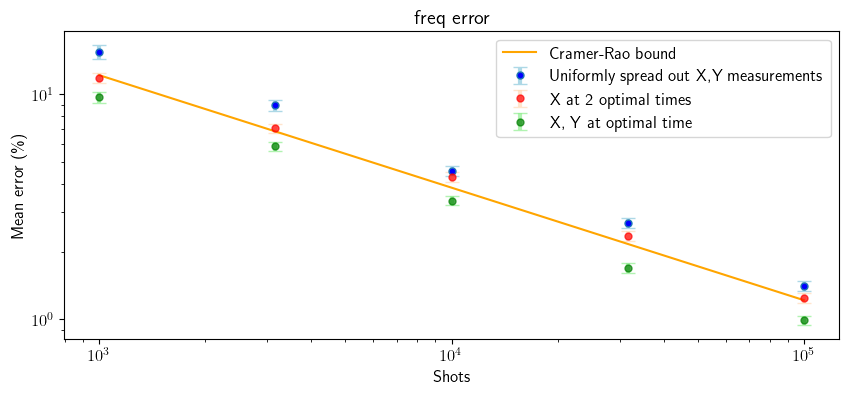

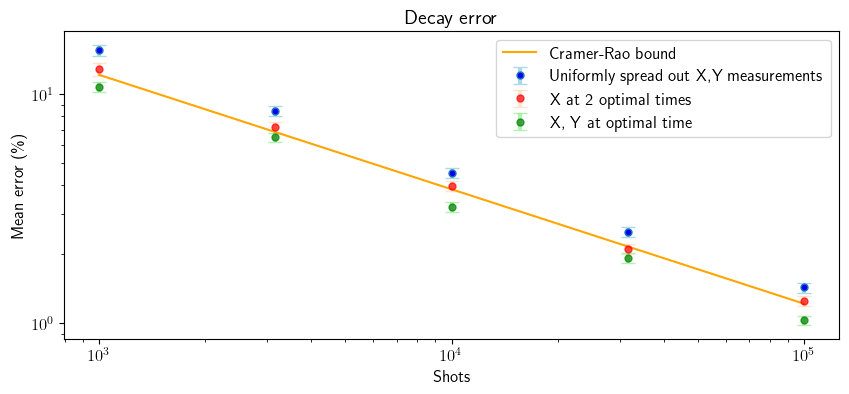

In [31]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.rcParams['text.usetex'] = True
font = {'family': 'normal',
        'weight': 'bold',
        'size': 14}# Adjust the figure size to make the plot longer
plt.rcParams['lines.markersize'] = 10
plt.rcParams['font.size'] = 12         # Example size for font


plt.errorbar(shots, 100*np.array(errors_uniform_median_w), yerr=100*np.array(errors_uniform_std_w), fmt='o', capsize=5, ecolor='lightblue', elinewidth=3, markerfacecolor='blue', markersize=5, label='Uniformly spread out X,Y measurements')

plt.errorbar(shots, 100*np.array(errors_fisher_median_w), yerr=100*np.array(errors_fisher_std_w), fmt='o', capsize=5, ecolor='peachpuff', elinewidth=3, color='red', markersize=5, label='X at 2 optimal times', alpha=0.7)

plt.errorbar(shots, 100*np.array(errors_local_median_w), yerr=100*np.array(errors_local_std_w), fmt='o', capsize=5, ecolor='lightgreen', elinewidth=3, color='green', markersize=5, label='X, Y at optimal time', alpha=0.7)


plt.plot(shots, 100*np.e/ np.sqrt(shots/2), '-', label='Cramer-Rao bound', color = 'orange')
plt.xlabel('Shots')
plt.ylabel('Mean error (\%)')
plt.yscale('log')
plt.title("freq error")
plt.xscale('log')
plt.legend()


plt.figure(figsize=(10, 4))
plt.errorbar(shots, 100*np.array(errors_uniform_median_a), yerr=100*np.array(errors_uniform_std_a), fmt='o', capsize=5, ecolor='lightblue', elinewidth=3, markerfacecolor='blue', markersize=5, label='Uniformly spread out X,Y measurements')

plt.errorbar(shots, 100*np.array(errors_fisher_median_a), yerr=100*np.array(errors_fisher_std_a), fmt='o', capsize=5, ecolor='peachpuff', elinewidth=3, color='red', markersize=5, label='X at 2 optimal times', alpha=0.7)

plt.errorbar(shots, 100*np.array(errors_local_median_a), yerr=100*np.array(errors_local_std_a), fmt='o', capsize=5, ecolor='lightgreen', elinewidth=3, color='green', markersize=5, label='X, Y at optimal time', alpha=0.7)

plt.plot(shots, 100*np.e/ np.sqrt(shots/2), '-', label='Cramer-Rao bound', color = 'orange')
plt.xlabel('Shots')
plt.ylabel('Mean error (\%)')
plt.yscale('log')
plt.xscale('log')
plt.title("Decay error")
plt.legend()

In [ ]:
import os
import pandas as pd
user_home = os.path.expanduser("~")

results_df = pd.DataFrame({
    "shots": shots,
    "errors_fisher_median_w": errors_fisher_median_w,
    "errors_fisher_std_w": errors_fisher_std_w,
    "errors_local_median_w": errors_local_median_w,
    "errors_local_std_w": errors_local_std_w,
    "errors_uniform_median_w": errors_uniform_median_w,
    "errors_uniform_std_w": errors_uniform_std_w,
})

# Saving to Excel
results_df.to_excel(
    user_home + r'\OneDrive - Bar-Ilan University - Students\Data\Crosstalk\graphs_for_paper\errors_optimal_w.xlsx',
    index=False)

results_df = pd.DataFrame({
    "shots": shots,
    "errors_fisher_median_a": errors_fisher_median_a,
    "errors_fisher_std_a": errors_fisher_std_a,
    "errors_local_median_a": errors_local_median_a,
    "errors_local_std_a": errors_local_std_a,
    "errors_uniform_median_a": errors_uniform_median_a,
    "errors_uniform_std_a": errors_uniform_std_a,
})

# Saving to Excel
results_df.to_excel(
    user_home + r'\OneDrive - Bar-Ilan University - Students\Data\Crosstalk\graphs_for_paper\errors_optimal_a.xlsx',
    index=False)